In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.loader import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from autoencoder import GIN, Decoder
from denoise_model import DenoiseNN, p_losses, sample
from utils import linear_beta_schedule

import csv
from utils import construct_nx_from_adj

import networkx as nx

# Datasets

In [31]:
train_dataset = torch.load('../data/dataset_train.pt')
valid_dataset = torch.load('../data/dataset_valid.pt')
test_dataset = torch.load('../data/dataset_test.pt')

/tmp/ipykernel_2497473/2199078535.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('../data/dataset_train.pt')


/tmp/ipykernel_2497473/2199078535.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  valid_dataset = torch.load('../data/dataset_valid.pt')
/tmp/ipykernel_2497473/219907853

We compute the mean and the standard deviation of the statistics in the training dataset to normalize the inputs to the decoder later on

In [32]:
stats = [graph.stats for graph in train_dataset]
stats = torch.stack(stats).squeeze()
stats_mean = stats.mean(dim=0)
stats_std = stats.std(dim=0)
stats_mean, stats_std

(tensor([3.0606e+01, 2.2626e+02, 1.2925e+01, 1.3899e+03, 5.0697e-01, 1.1442e+01,
         3.3475e+00]),
 tensor([1.1808e+01, 2.3441e+02, 1.0175e+01, 2.7951e+03, 3.2121e-01, 9.9933e+00,
         1.4503e+00]))

# VAE Model

In [70]:
class VAE7(nn.Module):

    def __init__(self, input_dim, hidden_dim_enc, hidden_dim_dec, latent_dim, n_layers_enc, n_layers_dec, n_max_nodes):
        super(VAE7, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encoder = GIN(input_dim, hidden_dim_enc, hidden_dim_enc, n_layers_enc).to(self.device)
        self.fc_mu = nn.Linear(hidden_dim_enc, latent_dim).to(self.device)
        self.fc_logvar = nn.Linear(hidden_dim_enc, latent_dim).to(self.device)
        self.decoder = Decoder(latent_dim + 7, hidden_dim_dec, n_layers_dec, n_max_nodes).to(self.device)

        self.latent_dim = latent_dim

        self.mean = stats_mean.to(self.device)
        self.std = stats_std.to(self.device)

    def forward(self, data):
        x_g = self.encoder(data)
        mu = self.fc_mu(x_g)
        logvar = self.fc_logvar(x_g)
        x_g = self.reparameterize(mu, logvar)
        stats = (data.stats - self.mean) / self.std
        x = torch.cat([x_g, stats], dim=1)
        adj = self.decoder(x)
        return adj

    def encode(self, data):
        x_g = self.encoder(data)
        mu = self.fc_mu(x_g)
        logvar = self.fc_logvar(x_g)
        x_g = self.reparameterize(mu, logvar)
        return x_g

    def reparameterize(self, mu, logvar, eps_scale=1.):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std) * eps_scale
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode_mu(self, mu):
       adj = self.decoder(mu)
       return adj

    def loss_function(self, data, beta=1.):
        x_g  = self.encoder(data)
        mu = self.fc_mu(x_g)
        logvar = self.fc_logvar(x_g)
        x_g = self.reparameterize(mu, logvar)
        stats = (data.stats - self.mean) / self.std
        x = torch.cat([x_g, stats], dim=1)
        adj = self.decoder(x)
        
        recon = F.l1_loss(adj, data.A, reduction='mean')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta*kld

        return loss, recon, kld
    
    def sample(self, stats):
        num_samples = stats.shape[0]
        z = torch.randn(num_samples, self.latent_dim).to(self.device)
        stats = (stats - self.mean) / self.std
        x = torch.cat([z, stats], dim=1)
        return self.decode_mu(x)


In [71]:
input_dim = 11
hidden_dim_enc = 128
hidden_dim_dec = 256
latent_dim = 32
n_layers_enc = 3
n_layers_dec = 3
n_max_nodes = 50

# Training the VAE

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE7(input_dim, hidden_dim_enc, hidden_dim_dec, latent_dim, n_layers_enc, n_layers_dec, n_max_nodes).to(device)

In [73]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [74]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

max_epochs = 200

In [75]:
for epoch in range(max_epochs):
    
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss, recon_loss, kl_loss = model.loss_function(data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()

    train_loss /= len(train_loader)
    train_recon_loss /= len(train_loader)
    train_kl_loss /= len(train_loader)

    model.eval()
    valid_loss = 0
    valid_recon_loss = 0
    valid_kl_loss = 0
    for data in valid_loader:
        data = data.to(device)
        loss, recon_loss, kl_loss = model.loss_function(data)
        valid_loss += loss.item()
        valid_recon_loss += recon_loss.item()
        valid_kl_loss += kl_loss.item()

    valid_loss /= len(valid_loader)
    valid_recon_loss /= len(valid_loader)
    valid_kl_loss /= len(valid_loader)

    print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Train Recon Loss: {train_recon_loss:.4f}, Train KL Loss: {train_kl_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Recon Loss: {valid_recon_loss:.4f}, Valid KL Loss: {valid_kl_loss:.4f}')

Epoch 1/200, Train Loss: 115.5196, Train Recon Loss: 0.2579, Train KL Loss: 115.2617, Valid Loss: 17.4435, Valid Recon Loss: 0.2298, Valid KL Loss: 17.2136
Epoch 2/200, Train Loss: 7.4096, Train Recon Loss: 0.1505, Train KL Loss: 7.2591, Valid Loss: 2.0380, Valid Recon Loss: 0.1840, Valid KL Loss: 1.8540
Epoch 3/200, Train Loss: 4.9477, Train Recon Loss: 0.1373, Train KL Loss: 4.8103, Valid Loss: 1.2883, Valid Recon Loss: 0.1752, Valid KL Loss: 1.1131
Epoch 4/200, Train Loss: 4.2591, Train Recon Loss: 0.1296, Train KL Loss: 4.1295, Valid Loss: 1.5157, Valid Recon Loss: 0.1617, Valid KL Loss: 1.3541
Epoch 5/200, Train Loss: 3.8762, Train Recon Loss: 0.1261, Train KL Loss: 3.7501, Valid Loss: 1.1578, Valid Recon Loss: 0.1496, Valid KL Loss: 1.0082
Epoch 6/200, Train Loss: 3.4527, Train Recon Loss: 0.1229, Train KL Loss: 3.3298, Valid Loss: 0.9806, Valid Recon Loss: 0.1418, Valid KL Loss: 0.8388
Epoch 7/200, Train Loss: 3.1735, Train Recon Loss: 0.1202, Train KL Loss: 3.0532, Valid Loss: 

# Visualization

In [76]:
## Visualize latent space
model.eval()
z_graphs = []
stat_text = []
for data in train_loader:
    data = data.to(model.device)
    z_graph = model.encode(data)
    z_graphs.append(z_graph.detach().cpu().numpy())
    stat_text.append(data.stats.detach().cpu().numpy())
z_graphs = np.concatenate(z_graphs)
stat_text = np.concatenate(stat_text)

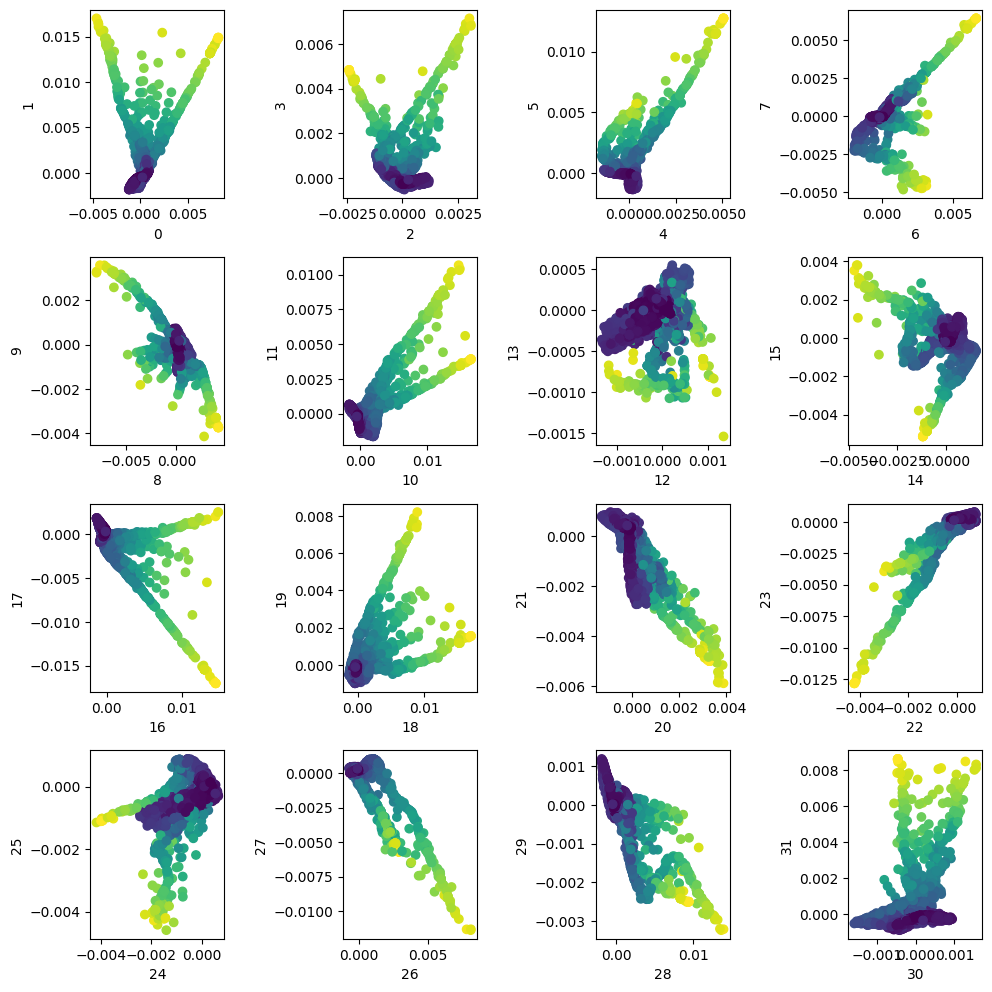

In [77]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    axs[i//4, i%4].scatter(z_graphs[:, 2*i], z_graphs[:, 2*i+1], c=stat_text[:, 3])
    axs[i//4, i%4].set_xlabel(f'{2*i}')
    axs[i//4, i%4].set_ylabel(f'{2*i+1}')
fig.tight_layout(pad=1.)

# Generate outputs using only the VAE

In [78]:
with open("../outputs/output_vae7_16.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["graph_id", "edge_list"])


    for data in test_loader:
        data = data.to(device)
        stats = data.stats
        adj = model.sample(stats)
        graph_ids = data.filename


        for i in range(stats.size(0)):
            stat_x = stats[i]

            Gs_generated = construct_nx_from_adj(adj[i,:,:].detach().cpu().numpy())
            stat_x = stat_x.detach().cpu().numpy()

            # Define a graph ID
            graph_id = graph_ids[i]

            # Convert the edge list to a single string
            edge_list_text = ", ".join([f"({u}, {v})" for u, v in Gs_generated.edges()])           
            # Write the graph ID and the full edge list as a single row
            writer.writerow([graph_id, edge_list_text])

# Train a latent diffusion model in this new latent space

In [18]:
hidden_dim_denoise = 512
n_layers_denoise = 3
n_condition = 7
dim_condition = 128
timesteps = 500
lr = 1e-3
max_epochs = 200

betas = linear_beta_schedule(timesteps=timesteps)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


denoise_model = DenoiseNN(input_dim=latent_dim, hidden_dim=hidden_dim_denoise, n_layers=n_layers_denoise, n_cond=n_condition, d_cond=dim_condition).to(device)
optimizer = torch.optim.Adam(denoise_model.parameters(), lr=lr)

In [20]:
for epoch in range(1, max_epochs+1):
    denoise_model.train()
    train_loss_all = 0
    train_count = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        x_g = model.encode(data)
        t = torch.randint(0, timesteps, (x_g.size(0),), device=device).long()
        loss = p_losses(denoise_model, x_g, t, data.stats, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, loss_type="huber")
        loss.backward()
        train_loss_all += x_g.size(0) * loss.item()
        train_count += x_g.size(0)
        optimizer.step()

    denoise_model.eval()
    val_loss_all = 0
    val_count = 0
    for data in valid_loader:
        data = data.to(device)
        x_g = model.encode(data)
        t = torch.randint(0, timesteps, (x_g.size(0),), device=device).long()
        loss = p_losses(denoise_model, x_g, t, data.stats, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, loss_type="huber")
        val_loss_all += x_g.size(0) * loss.item()
        val_count += x_g.size(0)

    if epoch % 1 == 0:
        print('Epoch: {:04d}, Train Loss: {:.5f}, Val Loss: {:.5f}'.format(epoch, train_loss_all/train_count, val_loss_all/val_count))


Epoch: 0001, Train Loss: 0.44316, Val Loss: 0.43305
Epoch: 0002, Train Loss: 0.42224, Val Loss: 0.43509
Epoch: 0003, Train Loss: 0.38642, Val Loss: 0.37708
Epoch: 0004, Train Loss: 0.33903, Val Loss: 0.33488
Epoch: 0005, Train Loss: 0.30243, Val Loss: 0.34311
Epoch: 0006, Train Loss: 0.26906, Val Loss: 0.29616
Epoch: 0007, Train Loss: 0.23479, Val Loss: 0.29443
Epoch: 0008, Train Loss: 0.20416, Val Loss: 0.22305
Epoch: 0009, Train Loss: 0.17979, Val Loss: 0.24221
Epoch: 0010, Train Loss: 0.16260, Val Loss: 0.23338
Epoch: 0011, Train Loss: 0.14310, Val Loss: 0.17135
Epoch: 0012, Train Loss: 0.13125, Val Loss: 0.14171
Epoch: 0013, Train Loss: 0.12084, Val Loss: 0.15192
Epoch: 0014, Train Loss: 0.11481, Val Loss: 0.17486
Epoch: 0015, Train Loss: 0.10566, Val Loss: 0.13213
Epoch: 0016, Train Loss: 0.10119, Val Loss: 0.17967
Epoch: 0017, Train Loss: 0.11393, Val Loss: 0.12672
Epoch: 0018, Train Loss: 0.08816, Val Loss: 0.12556
Epoch: 0019, Train Loss: 0.08258, Val Loss: 0.10868
Epoch: 0020,

# Generate outputs using the latent diffusion model

In [29]:
with open("../outputs/output_ldm7.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["graph_id", "edge_list"])


    for k, data in enumerate(test_loader):
        data = data.to(device)
        
        stat = data.stats
        bs = stat.size(0)

        graph_ids = data.filename

        samples = sample(denoise_model, data.stats, latent_dim=latent_dim, timesteps=timesteps, betas=betas, batch_size=bs)
        x_sample = samples[-1]
        z = torch.cat([x_sample, stat], dim=1)
        adj = model.decode_mu(z)
        stat_d = torch.reshape(stat, (-1, n_condition))


        for i in range(stat.size(0)):
            stat_x = stat_d[i]

            Gs_generated = construct_nx_from_adj(adj[i,:,:].detach().cpu().numpy())
            stat_x = stat_x.detach().cpu().numpy()

            # Define a graph ID
            graph_id = graph_ids[i]

            # Convert the edge list to a single string
            edge_list_text = ", ".join([f"({u}, {v})" for u, v in Gs_generated.edges()])           
            # Write the graph ID and the full edge list as a single row
            writer.writerow([graph_id, edge_list_text])